In [13]:
import os
import toml
import time
import json
from dotenv import load_dotenv
from src.document_loader import DocumentLoader
from src.embeddings import Embeddings
from src.vector_store import VectorStore
from src.retriever import Retriever
from src.llm import LLM
from src.rag_agent import RAGAgent

load_dotenv()

# env = os.getenv('ENV', 'development')
env = 'test'
# Load configuration
with open(f'config/config.{env}.toml', 'r') as file:
    config = toml.load(file)

model_id = config['model']['id']
document_directory = config['documents']['directory']
embedding_directory = os.path.join(document_directory, "embeddings")

loader = DocumentLoader(document_directory)
titles, documents = loader.load_documents()

huggingface_api_key = os.getenv("HUGGINGFACE_API_KEY")
if not huggingface_api_key:
    raise ValueError("HUGGINGFACE_API_KEY not found in environment variables")

embeddings = Embeddings(model_id=model_id, HUGGINGFACE_API_KEY=huggingface_api_key)
document_embeddings, chunked_texts_with_titles = embeddings.get_embeddings(titles, documents, embedding_directory=embedding_directory)

embedding_dimension = len(document_embeddings[0])
vector_store = VectorStore(dimension=embedding_dimension)
vector_store.add_documents(chunked_texts_with_titles, document_embeddings)

retriever = Retriever(vector_store, embeddings)
llm = LLM(config['llm']['api_url'])

rag_agent = RAGAgent(retriever=retriever, llm=llm)

queries = [
    "What is the main theme of the book Dracula?",
    # "Describe the character of Count Dracula.",
    # "What are the major settings in the book Dracula?",
    # "What are the significant symbols used in Dracula?",
    # "How does the author use foreshadowing in Dracula?",
    # "What is the role of Mina Harker in Dracula?",
    # "How does Bram Stoker create suspense in Dracula?",
    # "What is the significance of blood in Dracula?",
    # "How does the setting influence the mood in Dracula?",
    # "What are the Gothic elements in Dracula?"
]

average_latencies = []
output_speeds = []
times = []
query_lengths = []
results = []

for query in queries:
    prompt = rag_agent.get_prompt(query=query)
    prompt_tokens = len(prompt.split())
    
    start_time = time.time()
    answer = rag_agent.answer(query=query)
    end_time = time.time()
    
    response_tokens = len(answer.split())
    time_taken = end_time - start_time
    average_latency = time_taken
    output_speed = response_tokens / time_taken
    
    average_latencies.append(average_latency)
    output_speeds.append(output_speed)
    times.append(time_taken)
    query_lengths.append(prompt_tokens)
    
    result = {
        "query": query,
        "prompt_tokens": prompt_tokens,
        "response_tokens": response_tokens,
        "time_taken": time_taken,
        "output_speed": output_speed,
        "average_latency": average_latency
    }
    results.append(result)

# Summary statistics
summary = {
    "average_latency_sec": sum(average_latencies) / len(average_latencies),
    "output_speed_tokens_sec": sum(output_speeds) / len(output_speeds),
    "response_time_vs_query_length": list(zip(times, query_lengths))
}

# Add summary to results
results.append(summary)

# Save results to a file
timestamp = int(time.time())
output_directory = "evals/" + model_id.split('/')[0]
os.makedirs(output_directory, exist_ok=True)
output_file = os.path.join(output_directory, f"{model_id.split('/')[-1]}_{timestamp}.json")

with open(output_file, 'w') as file:
    json.dump(results, file, indent=4)

print(f"Results saved to {output_file}")

Results saved to evals/TinyLlama/TinyLlama-1.1B-Chat-v1.0_1723008419.json


In [11]:
model_id

'TinyLlama/TinyLlama-1.1B-Chat-v1.0'

In [9]:
import json
import matplotlib.pyplot as plt

In [17]:
filename = './evals/Meta-Llama-3-8B-Instruct_1723076030.json'
with open(filename, 'r') as file:
    data = json.load(file)

response_time_vs_query_length = data[-1]['response_time_vs_query_length']

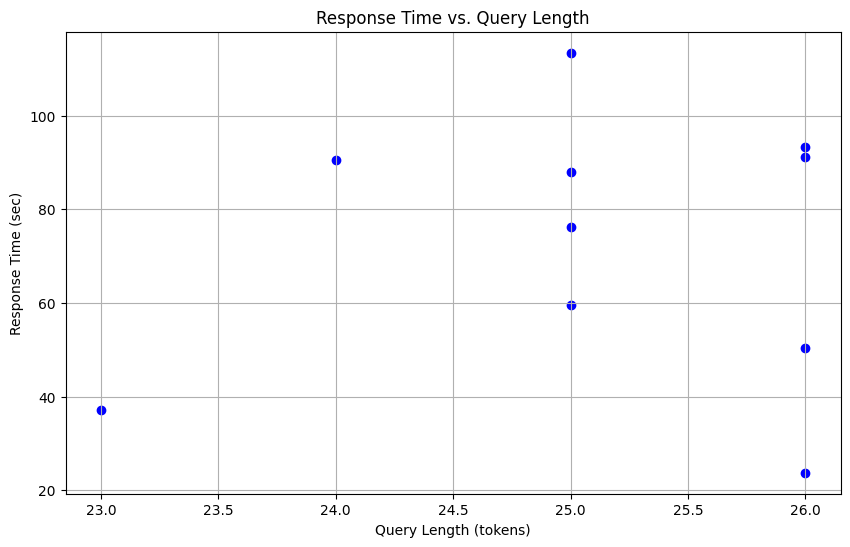

In [18]:
# Extracting the response times and query lengths
response_times = [item[0] for item in response_time_vs_query_length]
query_lengths = [item[1] for item in response_time_vs_query_length]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.scatter(query_lengths, response_times, color='blue')
plt.title('Response Time vs. Query Length')
plt.xlabel('Query Length (tokens)')
plt.ylabel('Response Time (sec)')
plt.grid(True)
plt.show()

In [16]:
plt.savefig('MetaLlama8.png')

<Figure size 640x480 with 0 Axes>